## Домашка 2
<h4><em>«Одно Кольцо, чтоб править всеми,<br>
Одно Кольцо, чтоб всех найти,<br>
Одно Кольцо, чтоб собрать всех в тени<br>
И заковать их всех во Тьме»</em><br>
— <em>Властелин колец</em>
</h4>

Эта домашка про приоритизацию метрик. За неё можно получить максимум 12 баллов. На решение отводится **14 календарных дней** с момента выдачи. Обратите внимание, что **дедлайны на курсе сразу жёсткие**, а значит отправка решений после них запрещена.
Задание выполняется самостоятельно, списывания не допускаются. При обнаружении одинаковых работ балл за задание анулируется у всех студентов, вне зависимости от того, кто у кого списал.

#### **Как сдать домашку?**
1. Создайте закрытый репозиторий в личном гитхаб аккаунте для нашего предмета.
2. Пригласите в него своего ассистента — распределение по ассистентам и их гитхаб юзернеймы находятся в [ведомости](https://docs.google.com/spreadsheets/d/13lHNf6xU6tZhqzVMAb8sV3RgyyDatepwo7FJ6FhZ0vY/edit?usp=sharing) на листочке нашей дисциплины. Это можно сделать в настройках через раздел Collaborators and teams, уровень доступа ассистента должен быть Write.
3. Скачайте этот ноутбук и решите задания (локально или в Google Colab).
4. В репозитории предмета создайте ветку с номером ДЗ (например hw_2). В эту ветку запушьте .ipynb-файл с решением. Создайте pull request и добавьте в него ассистента как Reviewer. В этот же PR можете пушить сколько угодно изменений, будем смотреть на последнюю версию до наступления дедлайна.
5. Ссылку на PR продублируйте в форме сдачи (форма будет доступна на LMS Karpov Courses и в Телеграм-канале курса).

Пункты 1-2 проделываются один раз. Если вы прошли эти шаги при сдаче других домашек, повторять их не нужно, начинайте сразу с пункта 3.

**Внимание**: Если вы работаете в Google Colab, также скачивайте .ipynb файл и публикуйте его в репозитории. Ссылки на Colab к сдаче не принимаются.

Все датасеты, с которыми предлагается работать в домашних заданиях, взяты из открытых источников или сгенерированы. Любые паттерны, найденные вне заданной канвы решения, являются случайными и не несут в себе смысла или инсайта.

[Данные](https://github.com/brezhnevaan/hse_product_metrics_course/releases/download/datasets_for_hw/hw_2_data.zip)

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

### Warm up

#### 1. Game dev — 2 балла
У вас есть данные о событиях в мобильной игре. Рассчитайте и визуализируйте:
- User Stickiness — отношение DAU к MAU (MAU рассчитывайте скользящим окном 30 дней для каждой даты только для полного окна)
- ARPDAU
- Paying Share — доля платящих пользователей
- Sessions per User — среднее число сессий на пользователя
- Daily Play Time — среднее время, проводимое пользователем в игре в день (рассчитываем как общее время в приложении)
- Avg Attempts per Session — среднее число попыток на сессию

*Смотрим на подневную динамику

In [2]:
df_game = pd.read_csv('/content/drive/MyDrive/hw_2_gamedev.csv', index_col=0)
df_game.head()

,session_id,user,date,revenue,attempts,session_length_sec
0,24590322,k0xevcHJ,2022-11-02,NaN,2.0,263
1,24590323,fMaLiagr,2022-11-02,NaN,10.0,953
2,24590324,0EXv0Q2V,2022-11-02,NaN,6.0,630
3,24590325,nY32SwuK,2022-11-02,NaN,9.0,1262
4,24590326,3KZkImTN,2022-11-02,NaN,16.0,2871


Описание данных (уникальный ключ session_id)

- session_id — уникальный идентификатор сессии
- user — уникальный идентификатор юзера
- date — дата
- revenue — суммарная выручка на сессию
- attempts — число попыток на сессию
- session_length_sec — длина сессии в секундах

In [3]:
# your code is here

In [4]:
df_game['date'] = pd.to_datetime(df_game['date'])

In [5]:
# Группируем по датам
daily = df_game.groupby('date').agg({
    'user': 'nunique',                # количество уникальных пользователей (DAU)
    'session_id': 'count',            # количество сессий
    'revenue': 'sum',                 # суммарная выручка
    'session_length_sec': 'sum',      # суммарное время в игре
    'attempts': 'sum'                 # общее количество попыток
}).rename(columns={'user': 'DAU'})

#1 User Stickiness (DAU / MAU)
df_game_sorted = df_game.sort_values('date')
rolling_mau = (
    df_game_sorted.groupby('date')['user']
    .apply(lambda x: df_game_sorted.loc[
        (df_game_sorted['date'].between(x.name - pd.Timedelta(days=29), x.name)),
        'user'
    ].nunique())
)
daily['MAU'] = rolling_mau
daily['Stickiness'] = daily['DAU'] / daily['MAU']

#2 ARPDAU
daily['ARPDAU'] = daily['revenue'] / daily['DAU']

#3 Paying Share
paying_daily = df_game.groupby('date').apply(lambda x: x.loc[x['revenue'] > 0, 'user'].nunique())
daily['Paying_Share'] = paying_daily / daily['DAU']

#4 Sessions per User
sessions_per_user = df_game.groupby('date').apply(lambda x: len(x) / x['user'].nunique())
daily['Sessions_per_User'] = sessions_per_user

#5 Daily Play Time
daily['Daily_Play_Time_min'] = (daily['session_length_sec'] / daily['DAU']) / 60

#6 Avg Attempts per Session
daily['Avg_Attempts_per_Session'] = daily['attempts'] / daily['session_id']

/tmp/ipython-input-4137442452.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paying_daily = df_game.groupby('date').apply(lambda x: x.loc[x['revenue'] > 0, 'user'].nunique())
/tmp/ipython-input-4137442452.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sessions_per_user = df_game.groupby('date').apply(lambda x: len(x) / x['user'].nunique())


In [6]:
import matplotlib.dates as mdates

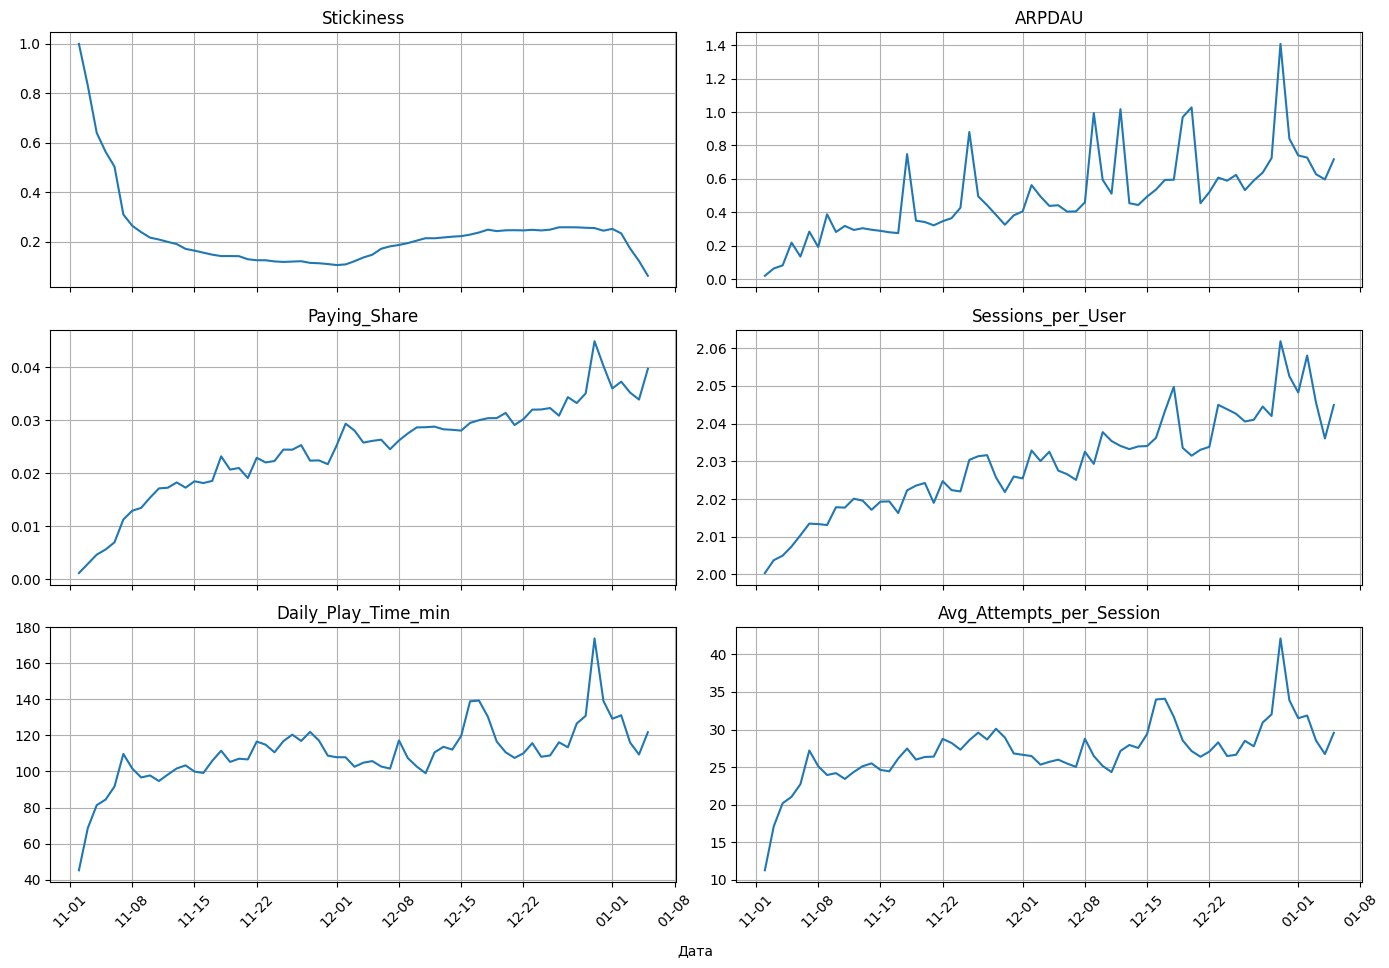

In [7]:
metrics = [
    'Stickiness', 'ARPDAU', 'Paying_Share',
    'Sessions_per_User', 'Daily_Play_Time_min', 'Avg_Attempts_per_Session'
]

fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].plot(daily.index, daily[metric])
    axes[i].set_title(metric)
    axes[i].grid(True)
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

fig.text(0.5, 0.04, 'Дата', ha='center')
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


Удержание падает (Stickiness вниз),
Монетизация нестабильная (ARPDAU скачет, Paying Share очень низкий),
Вовлечение внутри сессии (Attempts) растёт, но общее время и количество сессий начинают снижаться.

Гипотеза: игра интересна в геймплее (игроки делают больше попыток), но нет хорошо работающей системы возврата пользователей и монетизации

#### 2. Ride hailing  — 2 балла
У вас есть данные из приложения такси. Рассчитайте и визуализируйте:
- Ride Completion Rate — CR из заказа в завершенную поездку
- Acceptance Rate — доля заказов, принятых водителем (считаем, что приняты все заказы, кроме заказов со статусом 'No Driver Found')
- Cancellation Rate — доля отмененных заказов
- Rides per Driver — среднее число поездок на водителя
- Avg Ride Check — средний чек поездки
- Отношение RTA к ETA (что измеряет эта метрика?)

*Смотрим на подневную динамику

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df_rh = pd.read_csv('/content/drive/MyDrive/hw_2_taxi.csv')

In [10]:
df_rh.head()

,date,time,order_uid,order_status,passenger_id,vehicle_type,pickup_location,drop_location,ETA,RTA,...,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,fare,ride_distance,driver_ratings,customer_rating,payment_method
0,2024-01-01,00:19:34,2a11faf27f77eae8,Completed,CID8362794,Bike,Udyog Vihar,Ambience Mall,9.0,10.8,...,NaN,NaN,NaN,NaN,NaN,99.0,37.98,4.8,4.8,Cash
1,2024-01-01,01:35:18,33ed1f6bad78bdc8,Completed,CID8300238,Go Mini,Basai Dhankot,Madipur,6.0,8.5,...,NaN,NaN,NaN,NaN,NaN,114.0,39.29,4.2,4.1,Uber Wallet
2,2024-01-01,01:37:50,e2fc1fc520e93b85,Cancelled by Driver,CID2030746,Go Sedan,Tughlakabad,Greater Kailash,6.0,7.4,...,NaN,1.0,More than permitted people in there,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01,01:48:03,a130fd507acf7804,Cancelled by Driver,CID3231181,Auto,Palam Vihar,Kherki Daula Toll,5.0,NaN,...,NaN,1.0,Personal & Car related issues,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01,01:49:56,cae2db8689a422fa,Cancelled by Driver,CID3381661,Go Sedan,Narsinghpur,Pulbangash,3.0,6.2,...,NaN,1.0,More than permitted people in there,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Описание данных (уникальный ключ order_uid)

- date — дата создания заказа
- time — время создания заказа
- order_uid — уникальный идентификатор заказа
- order_status — статус заказа
- passenger_id — уникальный идентификатор пассажира
- vehicle_type — тип транспорта
- pickup_location — место отправления
- drop_location — место назначения
- ETA — прогнозное время прибытия водителя на место отправления (estimated time of arrival)
- RTA — реальное время прибытия водителя на место отправления (real time of arrival)
- driver_id — уникальный идентификатор водителя
- cancelled_rides_by_customer — флаг отмены поездки пассажиром
- reason_for_cancelling_by_customer — причина отмены поездки пассажиром
- cancelled_rides_by_driver — флаг отмены поездки водителем
- driver_cancellation_reason — причина отмены поездки водителем
- incomplete_rides — флаг незавершенной поездки
- incomplete_rides_reason — причина незавершенной поездки
- fare — цена поездки
- ride_distance – расстояние поездки
- driver_ratings — рейтинг водителя
- customer_rating — рейтинг пассажира
- payment_method – способ оплаты

In [11]:
df_rh.order_status.unique()

array(['Completed', 'Cancelled by Driver', 'No Driver Found',
       'Cancelled by Customer', 'Incomplete'], dtype=object)

In [12]:
# your code is here

In [13]:
#1 Ride Completion Rate — CR (заказ → завершённая поездка)
df_rh['is_completed'] = (df_rh['order_status'] == 'Completed').astype(int)

#2 Acceptance Rate — все заказы минус "No Driver Found"
df_rh['is_accepted'] = (df_rh['order_status'] != 'No Driver Found').astype(int)

#3 Cancellation Rate — доля отменённых (водителем или клиентом)
df_rh['is_cancelled'] = df_rh['order_status'].isin(
    ['Cancelled by Driver', 'Cancelled by Customer']).astype(int)

#4 Rides per Driver — среднее число поездок на водителя
rides_per_driver = df_rh.groupby('date')['driver_id'].nunique()
orders_per_driver = df_rh.groupby('date')['order_uid'].count() / rides_per_driver

#5 Avg Ride Check — средний чек поездки
avg_ride_check = df_rh.groupby('date')['fare'].mean()

#6 Отношение RTA к ETA
df_rh['RTA_to_ETA'] = df_rh['RTA'] / df_rh['ETA']
rta_eta_daily = df_rh.groupby('date')['RTA_to_ETA'].mean()

# Собираем подневные метрики
metrics_daily = df_rh.groupby('date').agg({
    'is_completed': 'mean',
    'is_accepted': 'mean',
    'is_cancelled': 'mean',
    'fare': 'mean'
}).rename(columns={
    'is_completed': 'CR',
    'is_accepted': 'AcceptanceRate',
    'is_cancelled': 'CancellationRate',
    'fare': 'AvgRideCheck'
})

metrics_daily['RidesPerDriver'] = orders_per_driver
metrics_daily['RTA_to_ETA'] = rta_eta_daily

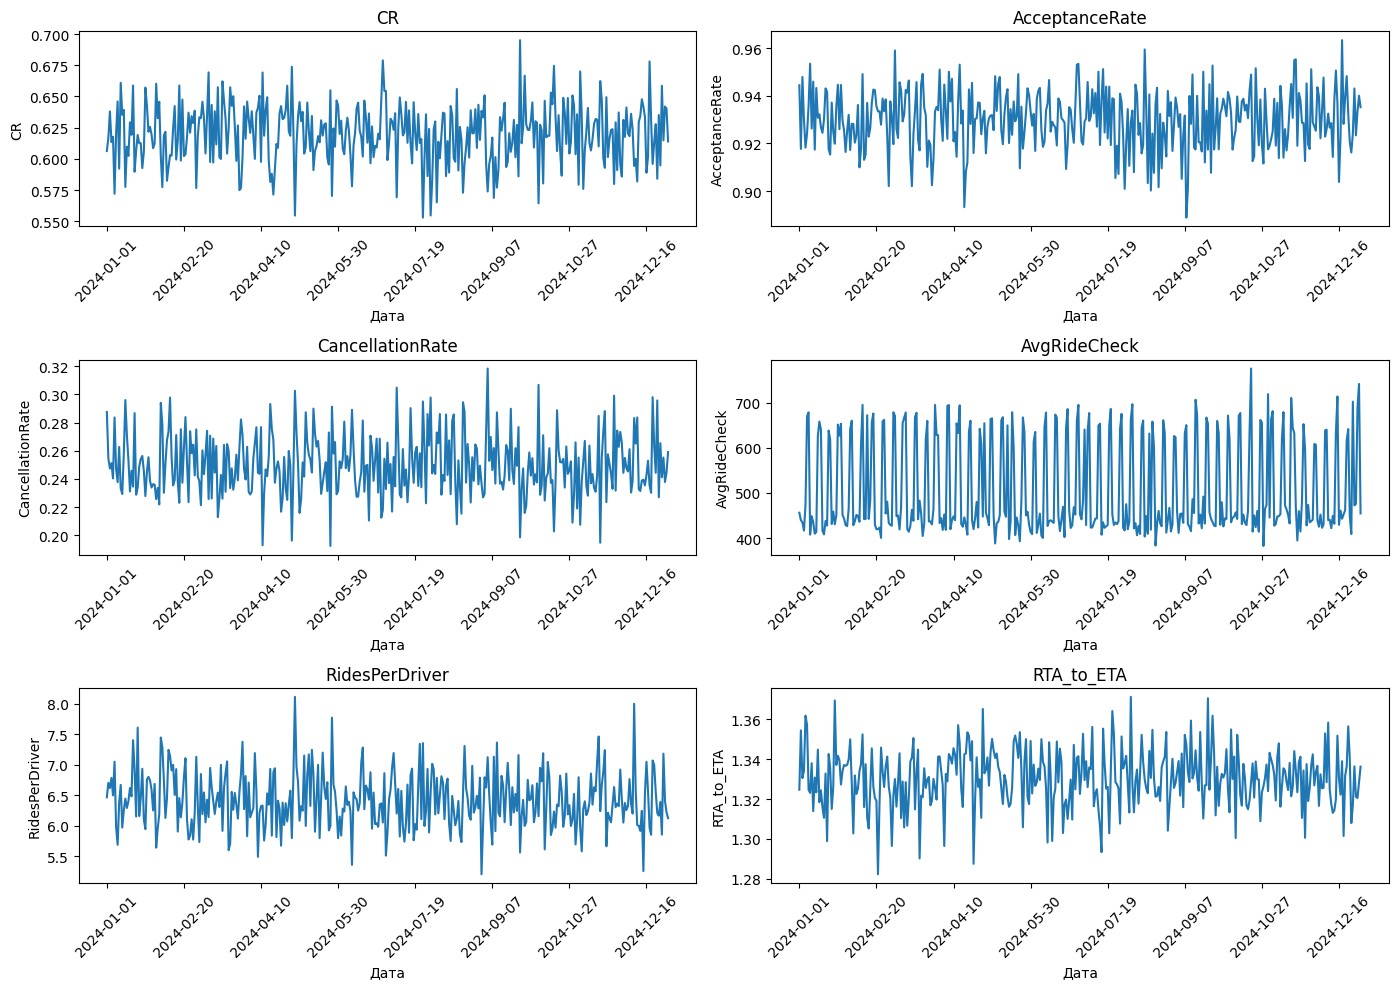

In [14]:
# Визуализация
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(metrics_daily.columns):
    metrics_daily[col].plot(ax=axes[i], title=col)
    axes[i].set_xlabel("Дата")
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

RTA / ETA
Показывает насколько реальное время прибытия отличается от прогнозного.
Если ~1 → прогноз точный.
Если >1 → водители приезжают дольше, чем ожидалось.
Если <1 → приезжают быстрее.

По графикам видно, что около 60–65% заказов завершаются поездкой, при этом водители принимают почти все заказы (Acceptance Rate ~0.93–0.95), а основная причина незавершённых поездок — отмены (Cancellation Rate ~0.22–0.28). Средний чек колеблется от 350 до 700, количество поездок на водителя — в среднем около 6 в день. При этом отношение RTA/ETA держится на уровне ~1.3, что говорит о систематическом опоздании водителей относительно прогнозируемого времени прибытия.

### Case Study. Запуск подкастов в стриминговом сервисе 🎧

**Легенда**  
Вы работаете продуктовым аналитиком в музыкальном стриминговом сервисе. Недавно в продукте запустился раздел с подкастами. Команда, отвечающая за запуск, хочет понять, стоит ли масштабировать и продвигать этот формат.

In [15]:
df_music_logs = pd.read_parquet('/content/drive/MyDrive/hw_2_streaming_logs.pqt')
df_music_subs = pd.read_parquet('/content/drive/MyDrive/hw_2_streaming_subs.pqt')

In [16]:
df_music_logs.head()

,datetime,uid,item_id,played_ratio_pct,track_length_seconds,content_type,is_first_date
0,2024-01-13 10:00:00,468300,7400764,100,225,music,0.0
1,2024-01-13 10:00:05,347600,3415205,100,250,music,0.0
2,2024-01-13 10:00:10,942900,6728180,1,270,music,0.0
3,2024-01-13 10:00:15,243500,5283544,100,195,music,0.0
4,2024-01-13 10:00:15,12700,8932363,100,245,music,0.0


In [17]:
df_music_subs.head()

,uid,start_date,end_date
0,600,2024-08-08,NaT
1,700,2024-03-29,NaT
2,800,2024-06-13,NaT
3,1100,2024-11-19,NaT
4,1400,2024-12-01,NaT


Описание данных hw_2_streaming_logs:

- datetime — дата-время взаимодействия с контентом
- uid — уникальный идентификатор пользователя
- item_id — уникальный идентификатор трека/эпизода
- played_ratio_pct — процент от длительности, который был воспроизведен
- track_length_seconds – длина трека/эпизода в секундах
- content_type — тип контента: музыка или подкаст
- is_first_date — флаг, является ли эта дата первой для пользователя в продукте

Описание данных hw_2_streaming_subs:

- uid — уникальный идентификатор пользователя
- start_date — дата начала подписки
- end_date — дата окончания подписки

#### 3. Метрики роста  — 2 балла

Рассчитайте и визуализируйте:
- DAU, MAU, WAU;
- Количество новых премиум-подписчиков (за неделю и месяц);
- Проникновение подкастов — долю юзеров, послушавших подкаст хотя бы раз (за неделю и месяц).

Сделайте выводы:
- Есть ли выраженный тренд?
- Нет ли подозрений, что с раскаткой раздела что-то могло пойти не так (изменение тренда, выраженные ступеньки)?
- Как выглядит адопшен? Можно ли предположить наличие каких-то эффектов в пользовательском взаимодействии с новым разделом?

In [18]:
# your code is here

In [19]:
df_music_logs = df_music_logs.copy()
df_music_subs = df_music_subs.copy()

df_music_logs['dt'] = pd.to_datetime(df_music_logs['datetime'])
df_music_logs['date'] = df_music_logs['dt'].dt.floor('D')

df_music_subs['start_date'] = pd.to_datetime(df_music_subs['start_date'])

# DAU / WAU / MAU (по уникам)
# DAU
dau = df_music_logs.groupby('date')['uid'].nunique()

# WAU (календарные недели)
wau = df_music_logs.groupby(pd.Grouper(key='dt', freq='W-MON'))['uid'].nunique()

# MAU (календарные месяцы)
mau = df_music_logs.groupby(pd.Grouper(key='dt', freq='M'))['uid'].nunique()

# Новые премиум-подписчики (количество за неделю и месяц)
new_weekly_subs = df_music_subs.groupby(df_music_subs['start_date'].dt.to_period('W-MON'))['uid'].nunique()
new_monthly_subs = df_music_subs.groupby(df_music_subs['start_date'].dt.to_period('M'))['uid'].nunique()

# Для удобного отображения — приведем индекс к Timestamp (начало периода)
new_weekly_subs.index = new_weekly_subs.index.start_time
new_monthly_subs.index = new_monthly_subs.index.to_timestamp('M')

# Проникновение подкастов (доля юзеров с podcast ≥1)
podcast_logs = df_music_logs[df_music_logs['content_type'] == 'podcast']

# НЕДЕЛЯ
weekly_podcast_users = podcast_logs.groupby(pd.Grouper(key='dt', freq='W-MON'))['uid'].nunique()
weekly_active_users  = df_music_logs.groupby(pd.Grouper(key='dt', freq='W-MON'))['uid'].nunique()
weekly_podcast_pen   = (weekly_podcast_users / weekly_active_users).sort_index()

# МЕСЯЦ
monthly_podcast_users = podcast_logs.groupby(pd.Grouper(key='dt', freq='M'))['uid'].nunique()
monthly_active_users  = df_music_logs.groupby(pd.Grouper(key='dt', freq='M'))['uid'].nunique()
monthly_podcast_pen   = (monthly_podcast_users / monthly_active_users).sort_index()

/tmp/ipython-input-3159153282.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mau = df_music_logs.groupby(pd.Grouper(key='dt', freq='M'))['uid'].nunique()
/tmp/ipython-input-3159153282.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_podcast_users = podcast_logs.groupby(pd.Grouper(key='dt', freq='M'))['uid'].nunique()
/tmp/ipython-input-3159153282.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_active_users  = df_music_logs.groupby(pd.Grouper(key='dt', freq='M'))['uid'].nunique()


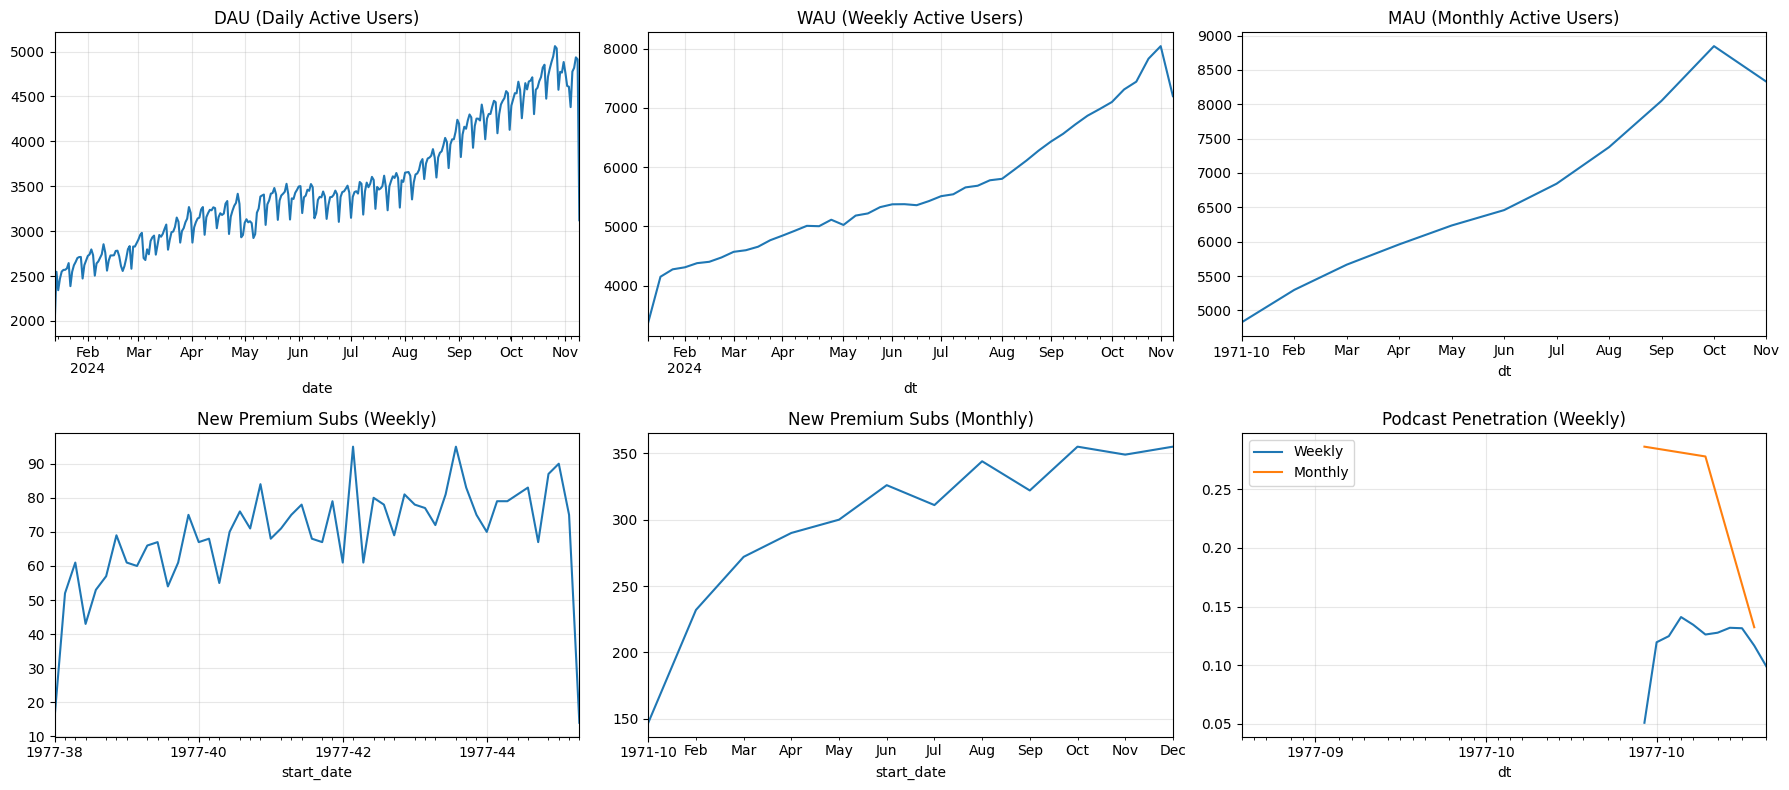

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

dau.plot(ax=axes[0,0], title='DAU (Daily Active Users)')
wau.plot(ax=axes[0,1], title='WAU (Weekly Active Users)')
mau.plot(ax=axes[0,2], title='MAU (Monthly Active Users)')

new_weekly_subs.plot(ax=axes[1,0], title='New Premium Subs (Weekly)')
new_monthly_subs.plot(ax=axes[1,1], title='New Premium Subs (Monthly)')

weekly_podcast_pen.plot(ax=axes[1,2], title='Podcast Penetration (Weekly)')
monthly_podcast_pen.plot(ax=axes[1,2])
axes[1,2].legend(['Weekly', 'Monthly'])

for ax in axes.flat:
    ax.grid(True, alpha=0.3)

for ax in [axes[1,0], axes[1,2]]:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))

for ax in [axes[0,2], axes[1,1], axes[1,2]]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

Тренд: DAU/WAU/MAU стабильно растут, новых подписчиков прибавляется равномерно.
Сбои: резких падений или ступенек нет, сезонные «зубцы» нормальны.
Адопшен: подкасты слушают всё больше, но проникновение пока низкое; рост плавный, без аномалий.

Итог: раскатка прошла нормально, аудитория растёт, подкасты постепенно осваиваются.

#### 4. Метрики продукта (шаг 1)  — 2 балла

Рассчитайте и визуализируйте как для всех пользователей в совокупности, так и для сегментов пользователей в разрезе — сделали / не сделали взаимодействие с подкастами (грубо говоря разделяем юзеров на тех, кто слушает только музыку и тех, кто слушает еще и подкасты):
1. Среднее время прослушивания на пользователя.
2. Среднее число треков/эпизодов на пользователя (среднее число item_id). Посчитайте метрику, как от уникальных, так и от не уникальных item_id. Подумайте, что показывает каждая из них?
3. Долю премиум-подписчиков. Обратите внимание, что нам нужна активная подписка, если пользователь отписался в том же периоде, что подписался, мы больше не считаем подписку активной.

Рассчитайте и визуализируйте как по всем item_id, так и в разрезе типов контента:
- Долю дослушанных треков/эпизодов до конца. Обратите внимание, данная метрика уже не пользовательская.

Периоды — неделя и месяц. Неполные периоды нужно обрезать, если они мешают чтению графиков.   
Признак взаимодействия присвайвайте только для периода, когда оно действительно было.   
Для месячной динамики метрик по признаку взаимодействия с подкастами у вас получится всего 2 точки, такая визуализая тоже полезна, она сглаживает недельные колебания и помогает оценивать тренд в масштабе года.

Сделайте выводы:
- Есть ли выраженный тренд?
- Изменилась ли метрика после запуска подкастов?
- Отличается ли метрика сегмента, взаимодействовавшего с подкастами, от тех, кто слушал только музыку? (будьте аккуратны с выводами в этом пункте, мы не проверяем изменение на каузальность, поэтому не можем быть уверены где причина, а где следствие)
- Есть ли отличия между типами контента?

*За взаимодействие с подкастами давайте считать только прослушивание >= 30% или более 2х минут контента*

In [ ]:
# your code is here

In [ ]:
df_music_logs['dt'] = pd.to_datetime(df_music_logs['datetime'])
df_music_logs['played_seconds'] = (
    df_music_logs['track_length_seconds'] * df_music_logs['played_ratio_pct'] / 100
)
df_music_subs['start_date'] = pd.to_datetime(df_music_subs['start_date'])
df_music_subs['end_date'] = pd.to_datetime(df_music_subs['end_date'])

# критерий взаимодействия с подкастами
df_music_logs['podcast_interaction'] = (
    (df_music_logs['content_type'] == 'podcast') &
    (
        (df_music_logs['played_ratio_pct'] >= 30) |
        (df_music_logs['played_seconds'] >= 120)
    )
)

# функция для агрегации
def agg_metrics(freq):
    active = df_music_logs.groupby(['uid', pd.Grouper(key='dt', freq=freq)]).agg(
        listened_time=('played_seconds','sum'),
        items_total=('item_id','count'),
        items_unique=('item_id','nunique'),
        podcast_flag=('podcast_interaction', 'any')   # << изменили тут
    ).reset_index()

    user_metrics = active.groupby(['dt','podcast_flag']).agg(
        avg_listen_time=('listened_time','mean'),
        avg_items_total=('items_total','mean'),
        avg_items_unique=('items_unique','mean'),
        users=('uid','count')
    )

    # премиум
    prem_share = {}
    for period, group in active.groupby('dt'):
        start = period.start_time if hasattr(period, 'start_time') else period
        end   = period.end_time   if hasattr(period, 'end_time') else period
        active_users = group['uid'].unique()
        subs = df_music_subs[
            (df_music_subs['start_date'] <= end) &
            ((df_music_subs['end_date'].isna()) | (df_music_subs['end_date'] >= start))
        ]['uid'].unique()
        if len(active_users) > 0:
            prem_share[period] = len(set(active_users) & set(subs)) / len(active_users)
        else:
            prem_share[period] = 0

    prem_share = pd.Series(prem_share, name='premium_share')

    # метрики по item_id (не пользовательские)
    item_metrics = df_music_logs.groupby([pd.Grouper(key='dt', freq=freq), 'content_type']).agg(
        listened_all=('played_ratio_pct', lambda x: (x==100).mean())
    )

    return user_metrics, prem_share, item_metrics

# считаем для недели и месяца
weekly_user, weekly_prem, weekly_item = agg_metrics('W-MON')
monthly_user, monthly_prem, monthly_item = agg_metrics('M')

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(22, 10))

# недельные метрики
weekly_user['avg_listen_time'].unstack().plot(
    ax=axes[0,0], marker='o', title='Avg listen time per user (Weekly)'
)
weekly_user['avg_items_total'].unstack().plot(
    ax=axes[0,1], marker='o', title='Avg items per user (Weekly)'
)
weekly_prem.plot(
    ax=axes[0,2], marker='o', title='Premium share (Weekly)'
)
weekly_item['listened_all'].unstack().plot(
    ax=axes[0,3], marker='o', title='Share fully played (Weekly)'
)

# месячные метрики
monthly_user['avg_listen_time'].unstack().plot(
    ax=axes[1,0], marker='o', title='Avg listen time per user (Monthly)'
)
monthly_user['avg_items_total'].unstack().plot(
    ax=axes[1,1], marker='o', title='Avg items per user (Monthly)'
)
monthly_prem.plot(
    ax=axes[1,2], marker='o', title='Premium share (Monthly)'
)
monthly_item['listened_all'].unstack().plot(
    ax=axes[1,3], marker='o', title='Share fully played (Monthly)'
)

# оформление
for ax in axes.flat:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 5. Метрики продукта (шаг 2)  — 2 балла

Рассчитайте и визуализируйте:
1) D1, D7, D30 retention по всем пользователям. Когорты агрегируйте по неделям т.к. из-за низкого числа новичков на дневном разрезе визуализации слишком шумные.
2) D30 retention для сегментов пользователей в разрезе — сделали / не сделали взаимодействие с подкастами на промежутке до 30 дня. Когорты агрегируйте по неделям.
3) D7 retention для сегментов пользователей в разрезе — сделали / не сделали взаимодействие с подкастами на промежутке до 7 дня. Когорты агрегируйте по месяцам.

Для наглядности будет полезно нарисовать на одном графике как посегментную, так и общую динамику (для этого можете достроить D7 retention для всех пользователей с помесячной агрегацией).

Сделайте выводы:
- Есть ли выраженный тренд?
- Изменилась ли метрика после запуска подкастов?
- Отличается ли метрика сегмента, взаимодействовавшего с подкастами, от тех, кто слушал только музыку? (будьте аккуратны с выводами в этом пункте, мы не проверяем изменение на каузальность, поэтому не можем быть уверены где причина, а где следствие)

*За взаимодействие с подкастами давайте считать только прослушивание >= 30% или более 2х минут контента*

In [ ]:
# your code is here

#### 6. Приоритизация метрик  — 2 балла

Составьте список всех метрик, которые были рассчитаны выше (не забудьте, что показатель, рассчитанный в разрезе сегмента — это отдельная метрика). Для простоты давайте ориентироваться только на недельную агрегацию.

1. Присвойте метрикам приоритеты P0-P3 по принципу (в этом пункте стройте приоритизацию на уровне всей компании):
   -  P0 — бизнес результат;
   -  P1 — метрики продукта, напрямую аффектящие бизнес-результат (retention, product as a habit);
   -  P2 — метрики, отражающие взаимодействие пользователя с продуктом (user experience, user engagement) / таргет-метрики отдельных команд продукта;
   -  P3 — метрики стримов / опыт пользователя в рамках работы отдельных команд.
2. Пересоберите приоритеты только для команды подкастов, если цель развития подкастов — рост пользователей с подпиской. Обратите внимание, что вам не нужно отказываться от метрик, рассчитанных по всем пользователям (без сегментов) или для сегмента Music (полезно понимать, не каннибализируем ли мы основной тип контента). Скорее всего приоритеты изменятся только для посегментных метрик.
4. Представьте, что цель внедрения подкастов поменялась — теперь команда в первую очередь хочет задрайвить вовлеченность в продукт. Пересоберите приоритеты при необходимости (в данном пункте могут измениться приоритеты для метрик, рассчитанных по всем пользователям).

Для каждого из пунктов дайте краткое обоснование, почему вы присвоили приоритеты именно так.

In [ ]:
# your answer is here